In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters

In [2]:
# Load the multi-frame TIFF (Z-Stack)
def load_tif_zstack(file_path):
    img_stack = io.imread(file_path)
    print(f"Loaded image stack with shape: {img_stack.shape}")  # (Z, Y, X) or (Z, Y, X, C) if multichannel
    return img_stack

In [3]:
# Compute Laplacian variance for each Z-slice
def compute_laplacian_variance(img_stack):
    variances = [np.var(filters.laplace(img_stack[z])) for z in range(img_stack.shape[0])]
    return variances

In [4]:
# Plot Laplacian variance vs Z-slice
def plot_laplacian_variance(variances):
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(variances)), variances, marker='o', linestyle='-')
    plt.xlabel("Z-Slice Number")
    plt.ylabel("Laplacian Variance")
    plt.title("Laplacian Variance across Z-Slices")
    plt.grid(True)
    plt.show()

In [5]:
# Visualize the slice with highest Laplacian variance
def show_highest_variance_slice(img_stack, variances):
    max_variance_index = np.argmax(variances)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(variances)), variances, marker='o', linestyle='-')
    plt.xlabel("Z-Slice Number")
    plt.ylabel("Laplacian Variance")
    plt.title("Laplacian Variance across Z-Slices")
    plt.grid(True)
    plt.xlim(0,20)
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_stack[max_variance_index], cmap='gray')
    plt.title(f'Slice with Highest Variance (Z-Slice {max_variance_index})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.savefig(file_path.replace(".tif", ".png"))
    print(f"The slice with the highest Laplacian variance is Z-Slice {max_variance_index}")

Loaded image stack with shape: (19, 3200, 3200)


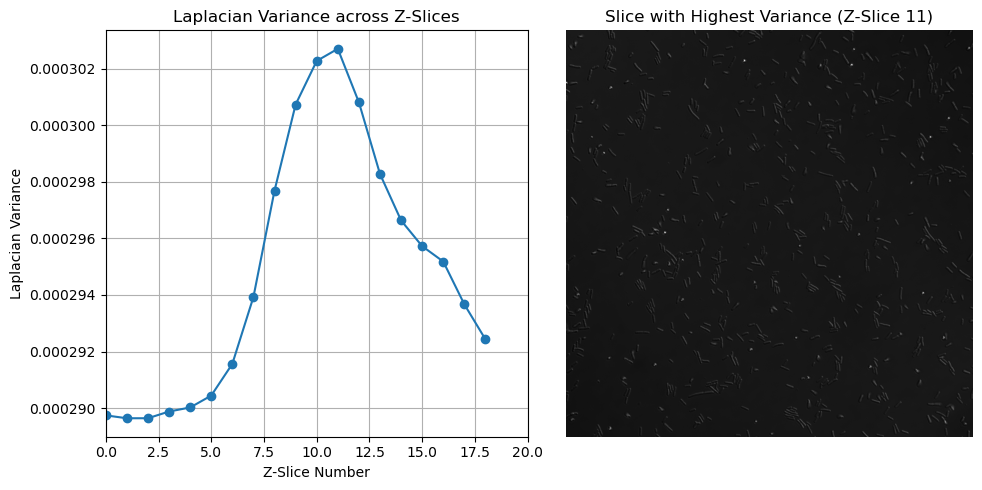

The slice with the highest Laplacian variance is Z-Slice 11


<Figure size 640x480 with 0 Axes>

In [6]:
# Example usage
file_path = "WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series06.tif"
img_stack = load_tif_zstack(file_path)
variances = compute_laplacian_variance(img_stack)
show_highest_variance_slice(img_stack, variances)

Loaded image stack with shape: (19, 3200, 3200)


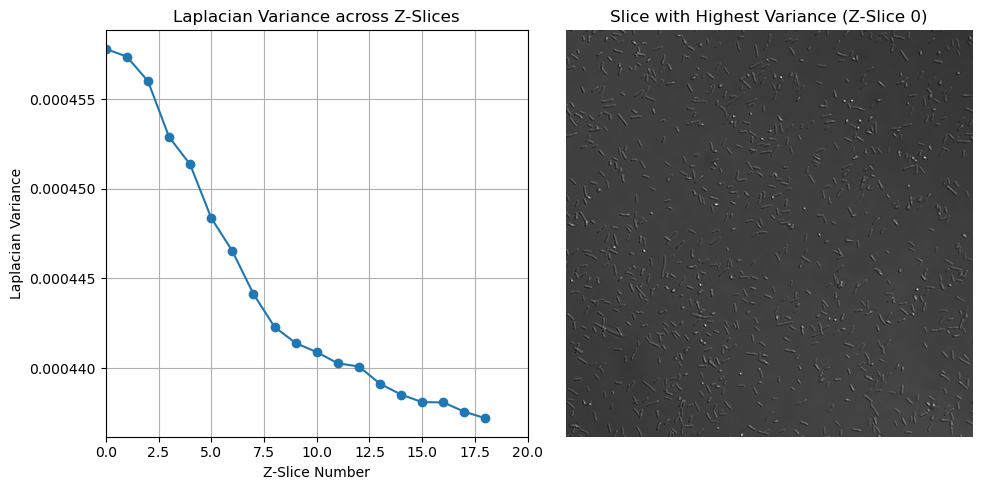

The slice with the highest Laplacian variance is Z-Slice 0
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

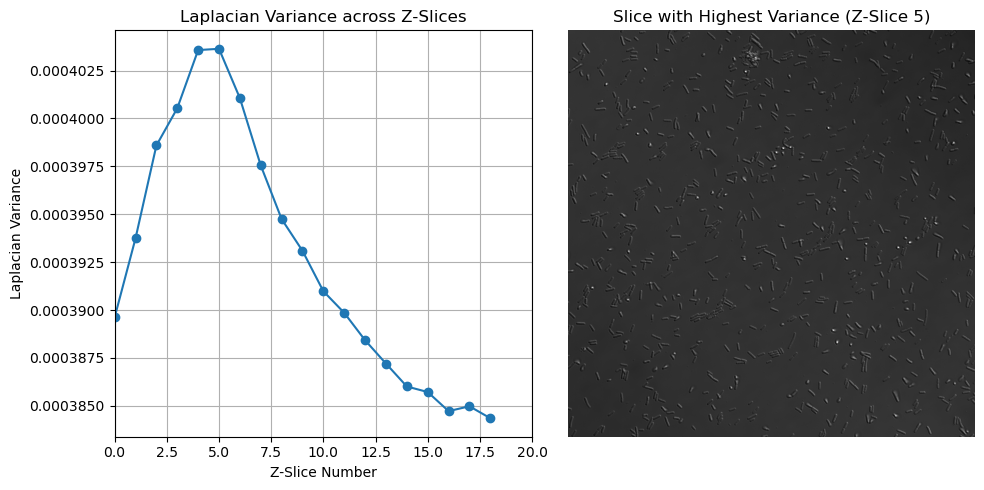

The slice with the highest Laplacian variance is Z-Slice 5
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series02.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

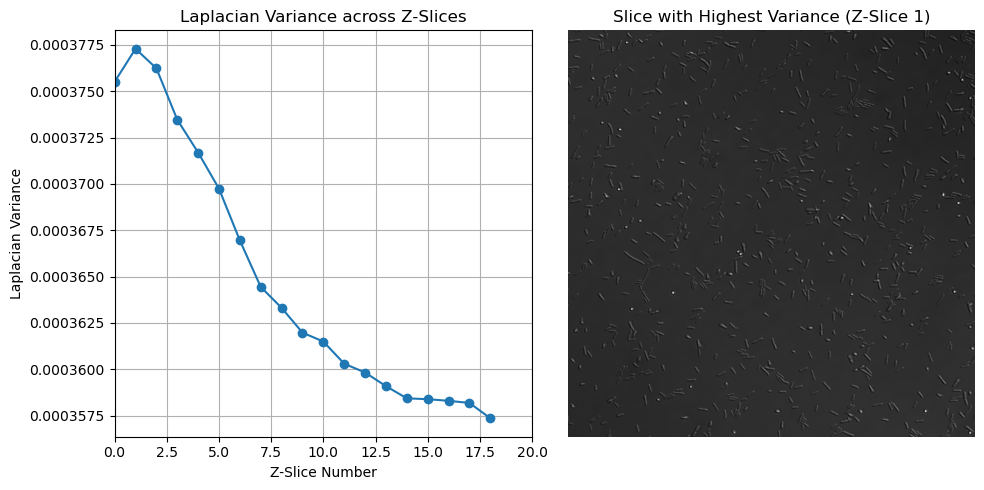

The slice with the highest Laplacian variance is Z-Slice 1
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series03.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

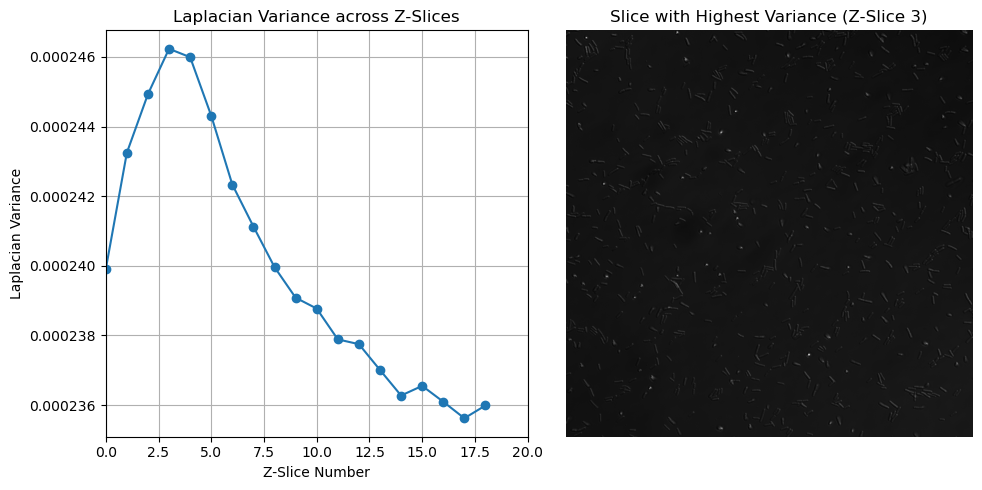

The slice with the highest Laplacian variance is Z-Slice 3
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series04.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

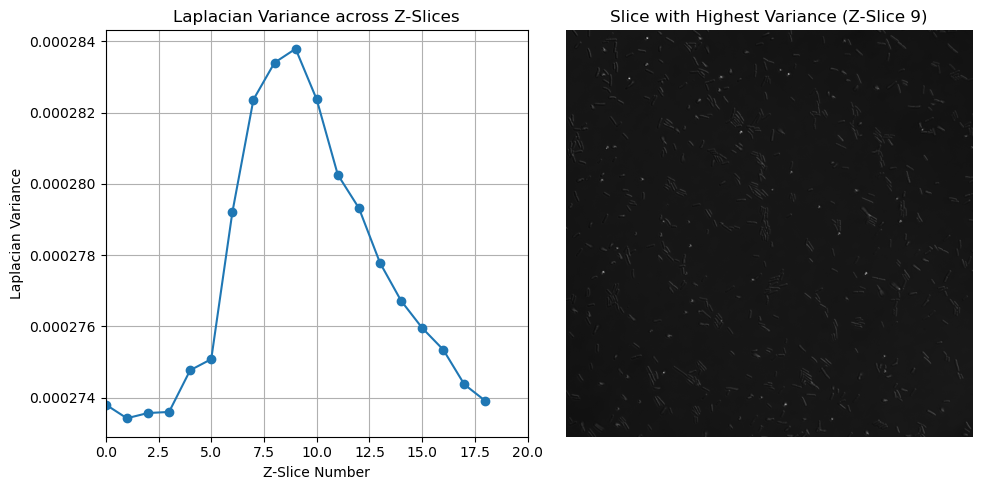

The slice with the highest Laplacian variance is Z-Slice 9
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series05.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

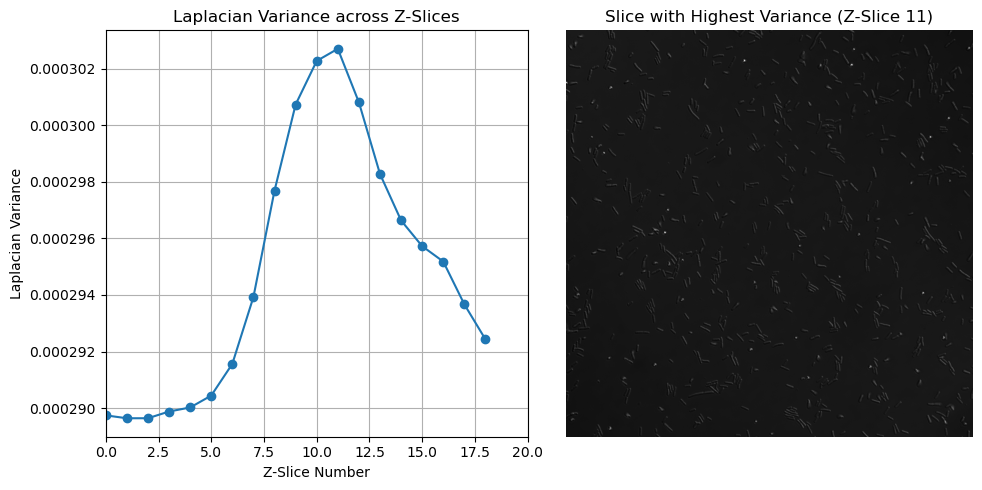

The slice with the highest Laplacian variance is Z-Slice 11
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series06.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

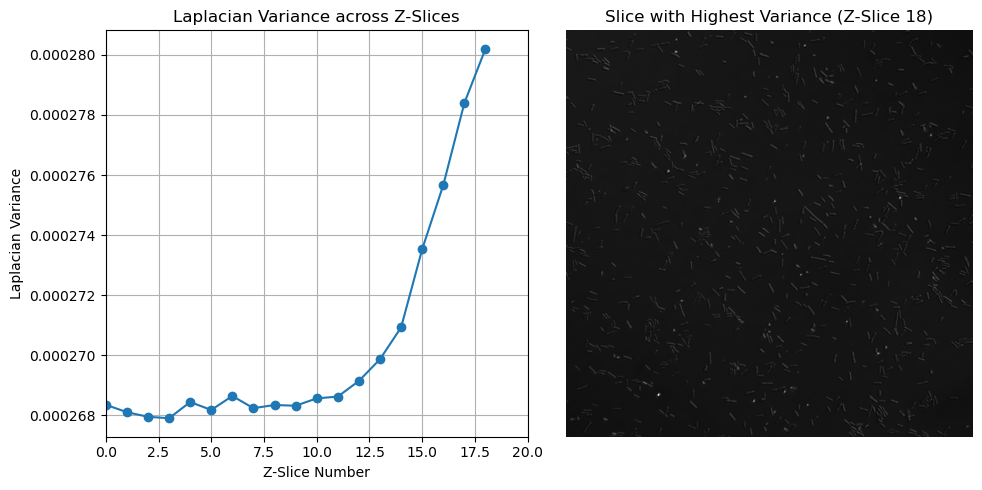

The slice with the highest Laplacian variance is Z-Slice 18
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series07.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

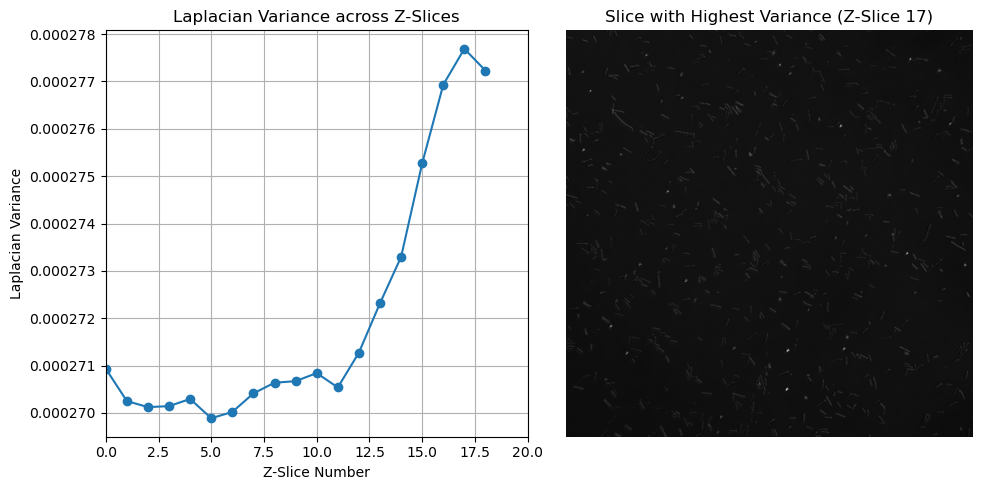

The slice with the highest Laplacian variance is Z-Slice 17
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series08.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

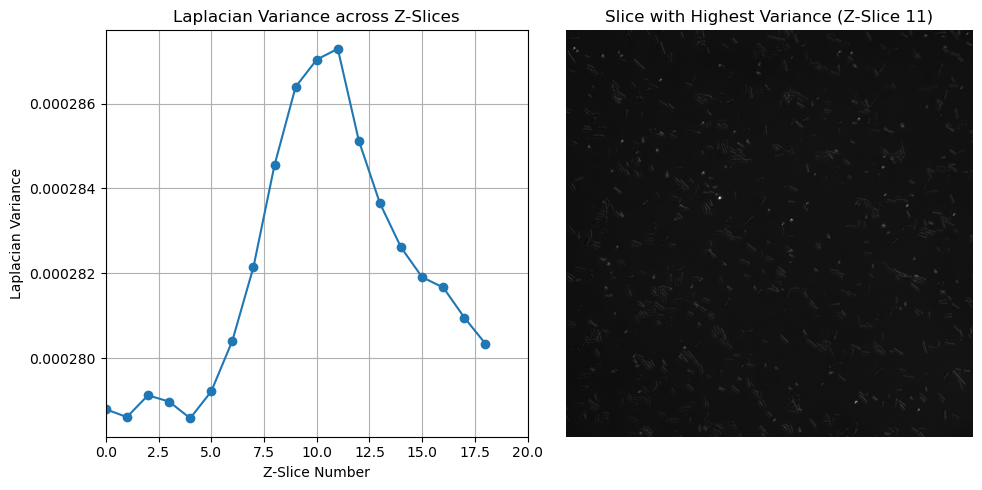

The slice with the highest Laplacian variance is Z-Slice 11
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series09.tif
---
Loaded image stack with shape: (19, 3200, 3200)


<Figure size 640x480 with 0 Axes>

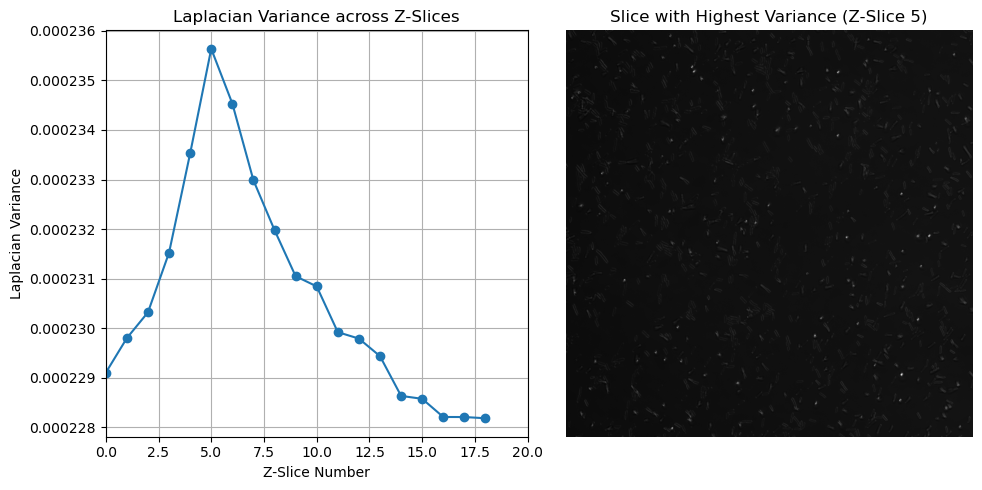

The slice with the highest Laplacian variance is Z-Slice 5
Analysis complete for WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series10.tif
---


<Figure size 640x480 with 0 Axes>

In [7]:
# Loop through all .tif files in the current directory
current_directory = os.getcwd()
for filename in os.listdir(current_directory):
    if filename.endswith(".tif"):
        file_path = os.path.join(current_directory, filename)
        output_path = os.path.join(current_directory, filename.replace(".tif", "_analysis.png"))
        
        img_stack = load_tif_zstack(file_path)
        variances = compute_laplacian_variance(img_stack)
        show_highest_variance_slice(img_stack, variances)
        print(f"Analysis complete for {filename}")
        print("---")

test for normal distribution of the laplacian variance

sobell filter
sum of laplace
